## Classifiers comparison on texts with naive Bayes assumption

In this session of laboratory we compare two models for categorical data probabilistic modeling: 
1. multivariate Bernoulli 
2. multinomial on a dataset 

We adopt a dataset on Twitter messages labelled with emotions (Joy vs Sadness).

The following program shows the loading of the data from a file.

Data are loaded into a matrix X adopting a sparse matrix representation, in order to save space and time.
Sparse matrix representation (in the csr format) represents in three "parallel" arrays the value of the matrix cells that are different from zero and the indices of those matrix cells.
The arrays are called: 
- data
- row
- col

- data[i] stores the value of the matrix cell #i whose indexes are contained in row[i] and col[i] 
- row[i] stores the index of the row in the matrix of the cell #i, 
- col[i] stores the index of the column of the cell #i.


The data file is in csv format.
Any Twitter message has been preprocessed by a Natural Language pipeline which eliminated stop words and substituted the interesting document elements with an integer identifier.  
The interesting document elements might be words, emoji or emoticons. The elements could be repeated in the same document and are uniquely identified in the documents by the same integer number.

Each row of the dataset is a list of integer number pairs, followed by a string which is the label of the document (Joy or sadness).
The first number of the pair is an identifier of an element (word, emoji or emoticon) and the second number of the pair is the count (frequency) of that element in that document.

The dataset has:
tot_n_docs=n_rows=11981
n_features (document elements)=11288



The following program reads the data file and loads in a sparse way the matrix using the scipy.sparse library

In [130]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.sparse import csr_matrix
from os.path import join

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import RocCurveDisplay, accuracy_score

data_path = './data/'
file_path = join(data_path, 'joy_sadness6000.txt')

class_labels = ['Joy', 'Sadness']
n_features = 11288  # number of columns in the matrix = number of features (distinct elements in the documents = word types in dataset)
n_rows = 11981  # number rows of the matrix (= rows in dataset)
n_elements = 71474  # number of the existing values in the matrix (not empty, to be loaded in the matrix in a sparse way)

In [131]:
# declare the row and col arrays with the indexes of the matrix cells (non empty) to be loaded from file
# they are needed because the matrix is sparse and we load in the matrix only the elements which are present

row = np.zeros(n_elements, dtype=int)
col = np.zeros(n_elements, dtype=int)
data = np.empty(n_elements, dtype=int)

twitter_labels = []  # list of class labels (target array) of the documents (twitter) that will be read from the input file
twitter_target = []  # list of 0/1 for class labels

with open(file_path) as fi:
    
    cur_el = 0  # position in the three arrays: row, col and data
    for (row_n, line) in enumerate(fi):
        el_list = line.split(',')
        l = len(el_list)
        class_name = el_list[l - 1].strip()  # grab the last element in the list which is the class label
        
        # twitter_labels contains the labels (Joy/Sadness)
        twitter_labels.append(class_name)
        # twitter_target contains 0/1 for the respective labels
        twitter_target.append(class_labels.index(class_name))

        i = 0  # I start reading all the doc elements from the beginning of the list
        while i < l - 1:
            element_id = int(el_list[i])  # identifier of the element in the document equivalent to the column index
            element_id = element_id - 1  # the index starts from 0 (the read id starts from 1)
            i = i + 1
            value_cell = int(el_list[i])  # make access to the following value in the file which is the count of the element in the document
            i = i + 1
            row[cur_el] = row_n  # load the data in the three arrays: the first two are the row and col indexes; the last one is the matrix cell value
            col[cur_el] = element_id
            data[cur_el] = value_cell
            cur_el = cur_el + 1

# loads the matrix by means of the indexes and the values in the three arrays just filled
twitter_data = csr_matrix((data, (row, col)), shape=(n_rows, n_features)).toarray()

#### Write a program in the following cell that splits the data matrix in training and test set (by random selection) and predicts the class (Joy/Sadness) of the messages on the basis of the words. 

Consider the two possible models:
 - multivariate Bernoulli
 - multinomial Bernoulli

Find the accuracy of the models and test if the observed differences are significant.

In [132]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(twitter_data, twitter_target, test_size=0.1, random_state=300)

Accuracy: 0.9416180150125104


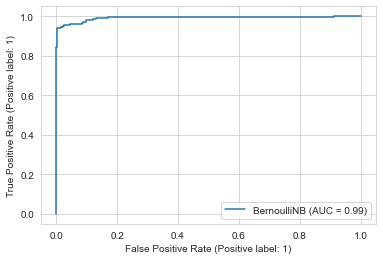

In [133]:
mv_clf = BernoulliNB().fit(X_train, y_train)
y_predicted = mv_clf.predict(X_test)
# scores = cross_val_score(bernoulli_clf, X_test, y_test, cv=5)
# print(f'Accuracy for Multivariate Bernoulli classifier: {scores}')

print(f'Accuracy: {accuracy_score(y_test, y_predicted)}')
roc_plot = RocCurveDisplay.from_estimator(mv_clf, X_test, y_test)

Accuracy: 0.9382819015846539


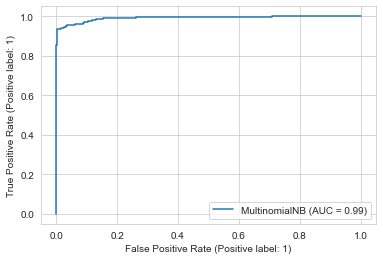

In [134]:
mn_clf = MultinomialNB().fit(X_train, y_train)
y_predicted = mn_clf.predict(X_test)
# scores = cross_val_score(multinomial_clf, X_test, y_test, cv=5)
# print(f'Accuracy for Multinomial Bernoulli classifier: {scores}')

print(f'Accuracy: {accuracy_score(y_test, y_predicted)}')
roc_plot = RocCurveDisplay.from_estimator(mn_clf, X_test, y_test)

### Statistical test to determine if the observed differences are statistically significant between the Multivariate and Multinomial probabilistic classifiers

Multivariate Bernoulli: [0.95663053 0.96577629 0.94991653 0.94991653 0.94824708 0.9524207
 0.95075125 0.95492487 0.9624374  0.93656093]
Accuracy: 0.9527582111414491 (var: 5.858405439130353e-05)


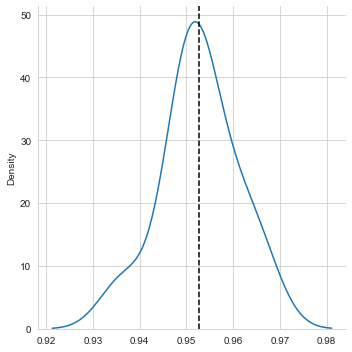

Multinomial Bernoulli: [0.95412844 0.96494157 0.94991653 0.94824708 0.94407346 0.94741235
 0.9490818  0.94991653 0.96160267 0.93739566]
Accuracy: 0.9506716086443767 (var: 5.750249027796592e-05)


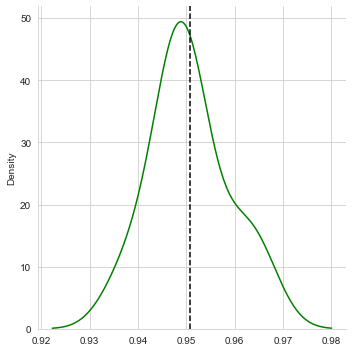

In [139]:
sns.set_style("whitegrid")

# Bernoulli multivariate 
mv_total_clf = BernoulliNB()
mv_scores = cross_val_score(mv_total_clf, twitter_data, twitter_target, cv=10)
print(f"Multivariate Bernoulli: {mv_scores}")
print(f"Accuracy: {mv_scores.mean()} (var: {mv_scores.var()})")
sns.displot(mv_scores, kind='kde')
plt.axvline(x=mv_scores.mean(), color='black', linestyle='--')
plt.show()

# Bernoulli multinomial
mn_total_clf = MultinomialNB()
mn_scores = cross_val_score(mn_total_clf, twitter_data, twitter_target, cv=10)
print(f"Multinomial Bernoulli: {mn_scores}")
print(f"Accuracy: {mn_scores.mean()} (var: {mn_scores.var()})")
sns.displot(mn_scores, kind='kde', color='g')
plt.axvline(x=mn_scores.mean(), color='black', linestyle='--')
plt.show()

Distribution of scores difference


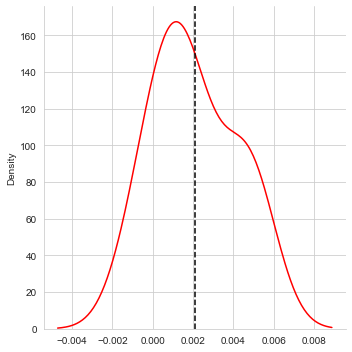

In [138]:
print('Distribution of scores difference')
sns.displot(mv_scores - mn_scores, kind='kde', color="r")
plt.axvline(x=(mv_scores - mn_scores).mean(), color='black', linestyle='--')

In [137]:
# H_0: Bernoulli multinomial and Bernoulli multivariate have identical average (expected) values
t_stat, p_value = stats.ttest_rel(mv_scores, mn_scores)

print(f't-stat: {t_stat}')
print(f'p-value: {p_value}')

alpha = 0.05
if p_value > alpha:
  print('Same distribution (fail to reject H_0)')
else:
  print('Different distribution (reject H_0)')

t-stat: 3.2123990690558073
p-value: 0.010617994606921194
Different distribution (reject H_0)


In conclusion, we reject null hypothesis because the chance of seeing no difference in average accuracy is approximately 1% (< α). The difference in the measured accuracy averages (μ1 - μ2 = 0.0028) is therefore statistically significant.

The result of the paired t-test support the hypothesis that the multivariate model has slightly better performances than the multinomial one in the case in question.